# Logistic regression baseline

>*Another strong baseline to evaluate is logistic regression*
> * *Evaluate the logistic regression baseline*
> * *Tune its regularization strength parameter with cross-validated grid-search*
> * *Pick ten images and compute the probability for each class using the predict_proba() function of your estimator. Plot the results for each image and comment your findings. For example, you can plot the ten images in subplots and collect the probabilities in a DataFrame.*
> * *Finally, vary the regularization strength of your estimator. What is the effect on the probabilities? Write your observations in a markdown cell.*

> *Note: Running a cross-validation on top of a grid search can computationally be very demanding. Under certain conditions, this might lead to a "never ending" model fit. We recommend that you use GridSearchCV together with verbose=1 to better understand how the computation is progressing. Also, if your computer provides parallel computation, you can use n_jobs=2 (or 4, 8 or -1) to specify how many parallel computation you want to allow.*



I am going to start by loading features and labels from all the sets (train, validation and test sets) and the images from the test sets for the third part of the exercise (plot 10 images).

In [1]:
# Import numpy
import numpy as np

# Load features and labels from npz files
with np.load('train.npz', allow_pickle=False) as npz_file:
    X_train=npz_file['features']
    y_train=npz_file['labels']
    names = npz_file['names']

with np.load('valid.npz', allow_pickle=False) as npz_file:
    X_valid=npz_file['features']
    y_valid=npz_file['labels']

with np.load('test.npz', allow_pickle=False) as npz_file:
    X_test=npz_file['features']
    y_test=npz_file['labels']
    # for the third part of the exercise
    test_images = npz_file['images']
    test_names = npz_file['names']

For this exercise I am going to merge the train and validation sets as the cross-validated grid search uses k-fold cross-validation to do the train/validation split.

In [2]:
X_train=np.concatenate((X_train,X_valid), axis=0)
y_train=np.concatenate((y_train,y_valid), axis=0)

### Logistic regression baseline

I am going to ignore convergence warnings when I run the logistic regressions.

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

I am going to run a multinomial logistic regression as there are more than two classes. As the default solver "liblinear" does not support softmax regressions I am going to change it to "saga".

In [4]:
from sklearn.linear_model import LogisticRegression

# Logistic regression
logreg = LogisticRegression(multi_class='multinomial', solver='saga')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [5]:
# Get test accuracy
logreg.score(X_test, y_test)

0.9333333333333333

### Tune regularization strength

In order to tune the regularization strength parameter with cross-validated grid-search, I am going to use the k-fold object with suffle as the validation set was not suffled when saved during the feature extraction. Then, I am going to use 5 splits for the cross-validation and test ten C values between 0.0001 and 10000.

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Create k-fold object
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Create cross-validation object
grid = {
    'C': np.logspace(-4, 4, num=10)
}
grid_cv = GridSearchCV(logreg, grid, cv=kfold, return_train_score=True, verbose=1, n_jobs=2)

In [7]:
# Fit estimator
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   42.6s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   46.2s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'C': array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

Now I am going to save the results in a dataframe and sort it by the mean of the test scores.

In [8]:
import pandas as pd

# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# Print a few interesting columns
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_C']
cv_results[cols].sort_values('mean_test_score', ascending=False)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_C
4,0.916667,0.019920,1.000000,0.000000,0.359381
5,0.916667,0.019920,1.000000,0.000000,2.78256
8,0.916667,0.019920,1.000000,0.000000,1291.55
3,0.914286,0.021822,1.000000,0.000000,0.0464159
6,0.914286,0.017496,1.000000,0.000000,21.5443
7,0.914286,0.017496,1.000000,0.000000,166.81
9,0.911905,0.019343,1.000000,0.000000,10000
2,0.909524,0.019343,0.986905,0.004037,0.00599484
1,0.864286,0.024513,0.904167,0.006070,0.000774264
0,0.685714,0.058612,0.708333,0.019471,0.0001


Let's plot the test score results to have a better view.

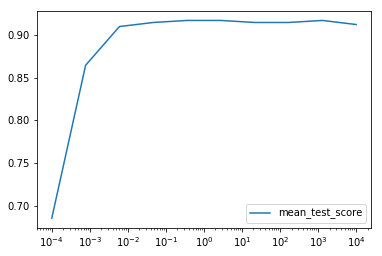

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot test curve
plt.semilogx(cv_results['param_C'], cv_results['mean_test_score'])
plt.legend()
plt.show()

We can see that the accuracy increases sharply when the C value moves from 0.0001 to 0.01 but then the accuracy results are similar when the C value varies between 0.01 and 10000. Therefore, the logistic regression baseline wasn't overfitting and adding regularization hurts performance.

In [10]:
# get the test_accuracy of the grid search best estimator
test_accuracy=grid_cv.score(X_test, y_test)
test_accuracy

0.9333333333333333

In [11]:
# save results in a data frame
results=pd.DataFrame({
        'model': ['logistic'],
        'test_accuracy': '{:.3f}'.format(test_accuracy)
    })

In [12]:
# add results to csv file
pd.read_csv('results.csv').append(results).to_csv('results.csv', index=False)

### Pick ten images and compute the probability for each class

I am going to plot 10 images from the test set and show the probabilities for each class using the best estimator of the grid search performed above.

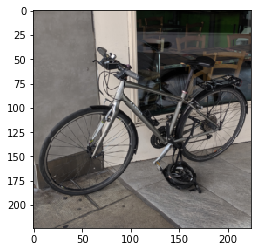

             probability
       bike     0.999493
        car     0.000059
 motorcycle     0.000044
      other     0.000366
      truck     0.000020
        van     0.000017


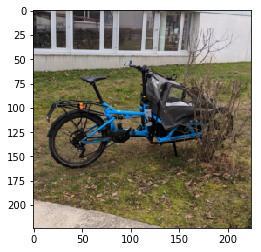

             probability
       bike     0.840277
        car     0.005509
 motorcycle     0.078041
      other     0.072409
      truck     0.003099
        van     0.000665


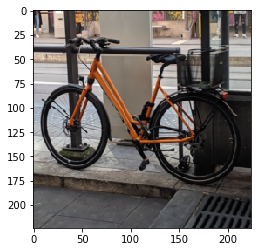

             probability
       bike     0.999750
        car     0.000010
 motorcycle     0.000011
      other     0.000198
      truck     0.000023
        van     0.000008


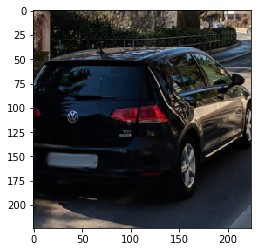

             probability
       bike     0.000038
        car     0.997425
 motorcycle     0.000011
      other     0.000281
      truck     0.000004
        van     0.002240


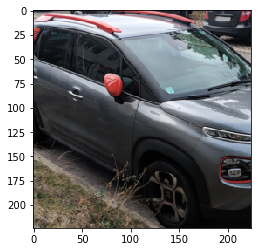

             probability
       bike     0.000278
        car     0.994054
 motorcycle     0.000057
      other     0.000173
      truck     0.000107
        van     0.005332


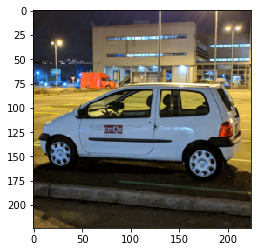

             probability
       bike     0.000821
        car     0.742284
 motorcycle     0.000291
      other     0.000792
      truck     0.000814
        van     0.254997


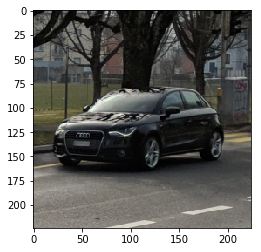

             probability
       bike     0.000025
        car     0.999430
 motorcycle     0.000024
      other     0.000038
      truck     0.000009
        van     0.000474


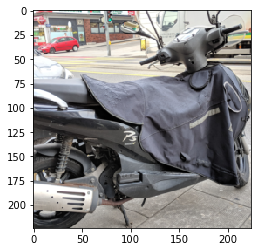

             probability
       bike     0.001190
        car     0.004466
 motorcycle     0.969728
      other     0.023878
      truck     0.000714
        van     0.000023


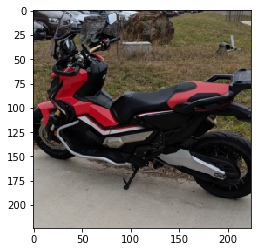

             probability
       bike     0.000288
        car     0.000351
 motorcycle     0.998930
      other     0.000239
      truck     0.000147
        van     0.000045


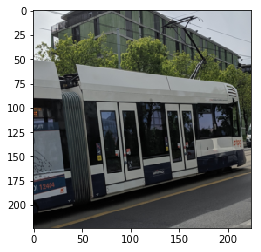

             probability
       bike     0.002896
        car     0.000402
 motorcycle     0.001342
      other     0.964655
      truck     0.021996
        van     0.008708


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

for photo in np.arange(0,50,5):
    plt.imshow(test_images[photo])
    plt.show()
    prob_labels=pd.DataFrame({
        ' ': names,
        'probability': grid_cv.predict_proba(X_test)[photo]
    })
    print(prob_labels.to_string(index = False))

### Vary the regularization strength of the estimator and see the effect on the probabilities

I am going to compare the probabilities for the ten images when the C value is very low (0.0001), equal to default (1) and very high (10000). For that, I am going to run the logistic regression three times and compute the probabilities for the ten images for every regression. Then, I am going to save the results in a dataframe.

In [14]:
prob=[]
C_values=[]
image_number=[]

#Go through the C values
for C_value in np.array([0.0001,1,10000]):
    logreg = LogisticRegression(multi_class='multinomial', solver='saga', C=C_value)
    logreg.fit(X_train, y_train)
    
    #Go through the ten images
    for photo in np.arange(0,50,5):
        #compute and save the probabilities 
        prob.append(logreg.predict_proba(X_test)[photo])
        C_values.append(C_value)
        image_number.append(photo)

In [15]:
compare_prob=pd.DataFrame(prob, columns=names)
compare_prob['C']=C_values
compare_prob['image']=image_number

In [16]:
compare_prob.sort_values(by=['image','C'])

,bike,car,motorcycle,other,truck,van,C,image
0,0.420074,1.501370e-01,1.498035e-01,0.096633,1.121564e-01,7.119591e-02,0.0001,0
10,0.999879,7.877947e-06,8.239739e-06,0.000100,2.968737e-06,1.891181e-06,1.0000,0
20,0.999934,3.468852e-06,2.394959e-06,0.000058,1.330860e-06,8.107653e-07,10000.0000,0
1,0.300950,1.746701e-01,1.997125e-01,0.112636,1.318446e-01,8.018649e-02,0.0001,5
11,0.882459,1.899033e-03,5.907311e-02,0.055002,1.375906e-03,1.905772e-04,1.0000,5
21,0.910199,1.371019e-03,4.575491e-02,0.041811,7.839109e-04,7.977893e-05,10000.0000,5
2,0.447468,1.349847e-01,1.437236e-01,0.094095,1.110857e-01,6.864248e-02,0.0001,10
12,0.999946,8.550596e-07,1.701426e-06,0.000048,3.075535e-06,6.562915e-07,1.0000,10
22,0.999966,3.941563e-07,5.875852e-07,0.000031,1.912226e-06,3.597283e-07,10000.0000,10
3,0.150630,3.959449e-01,1.345013e-01,0.105506,1.235230e-01,8.989506e-02,0.0001,15


We can clearly see here that when the C value is very low the results show low variance but high bias. On the contrary, when the C value is very high the results show high variance but low bias. As mentioned before, adding regularization hurts performance in this case.